# Merge the output (dictionary) from the MPI runs into a Dataframe. 
Columns

* cluster_id
* mvir
* x
* y
* z
* redshift
* R_vir
* DS
* Sigma
* Ngal

## Setup

In [2]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import pickle5 as pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import pickle
import os
from glob import glob
import pickle

In [3]:
from timeit import default_timer as timer

In [4]:
ptcl_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p49/'
deltasigma_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'
clusters_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'

## Import the files

### Delta_Sigma_files

In [5]:
delta_sigma_file = deltasigma_dir + 'sigma_mvir_5e13_1e14_z0p49.pkl'
DS_files = glob(deltasigma_dir + 'sigma_m200c_*')
print(DS_files)

deltasigma_df = pd.DataFrame()

['/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/sigma_m200c_all_z0p00.pkl', '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/sigma_m200c_all_z0p49.pkl', '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/sigma_m200c_all_z1p03.pkl']


In [6]:
with open(delta_sigma_file, 'rb') as handle:
    deltasigma = pickle.load(handle)
    
    
for file in iter(DS_files):
    with open(file,'rb') as handle:
        deltasigma_cur = pickle.load(handle)
        deltasigma_cur_df = pd.DataFrame.from_dict(deltasigma_cur, orient="index").transpose()
    deltasigma_df = deltasigma_df.append(deltasigma_cur_df)

### Diagnostic plots

In [7]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

In [8]:
mean_sigma_mpi = np.mean(deltasigma['sigma'], axis=0)
mean_deltasigma_mpi = np.mean(deltasigma['delta_sigma'], axis=0)

sigma_err_mpi = np.std(deltasigma['sigma'], axis=0)
deltasigma_err_mpi = np.std(deltasigma['sigma'], axis=0)

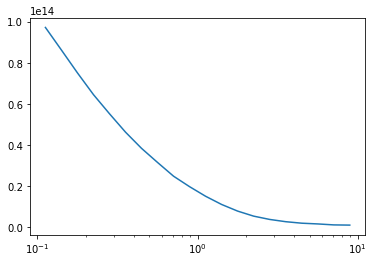

In [9]:
plt.plot(r_cent_lin_norm, mean_deltasigma_mpi)
plt.xscale('log'); #plt.yscale('log')
plt.show()

In [10]:
deltasigma_df = deltasigma_df.rename(columns={"cluster_id": "CtreesHaloID"})

### Matched halo files

In [11]:
matched_halo_df = pd.read_csv(clusters_dir + 'clusters_m200c_lgt_3e13_mah_allz_Ngal.csv')

In [12]:
matched_halo_df.columns

Index(['scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x', 'y', 'z',
       'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c'],
      dtype='object')

### Extract columns from the merged files. 

In [13]:
merged_df = pd.merge(matched_halo_df, deltasigma_df, how="inner", on='CtreesHaloID')

In [14]:
matched_halo_df = merged_df

## Plot the DeltaSigma in each bin

In [15]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

a_bins = [1, 0.6712, 0.4922]
column_name ='Acc_Rate_2*Tdyn'

M5e+13-1e+14, z=0.00, N=387
M5e+13-1e+14, z=0.49, N=449
M5e+13-1e+14, z=1.03, N=474
M1e+14-2e+14, z=0.00, N=507
M1e+14-2e+14, z=0.49, N=506
M1e+14-2e+14, z=1.03, N=505
M2e+14-5e+14, z=0.00, N=547
M2e+14-5e+14, z=0.49, N=535
M2e+14-5e+14, z=1.03, N=307
M5e+14-1e+15, z=0.00, N=495
M5e+14-1e+15, z=0.49, N=142
M5e+14-1e+15, z=1.03, N=8


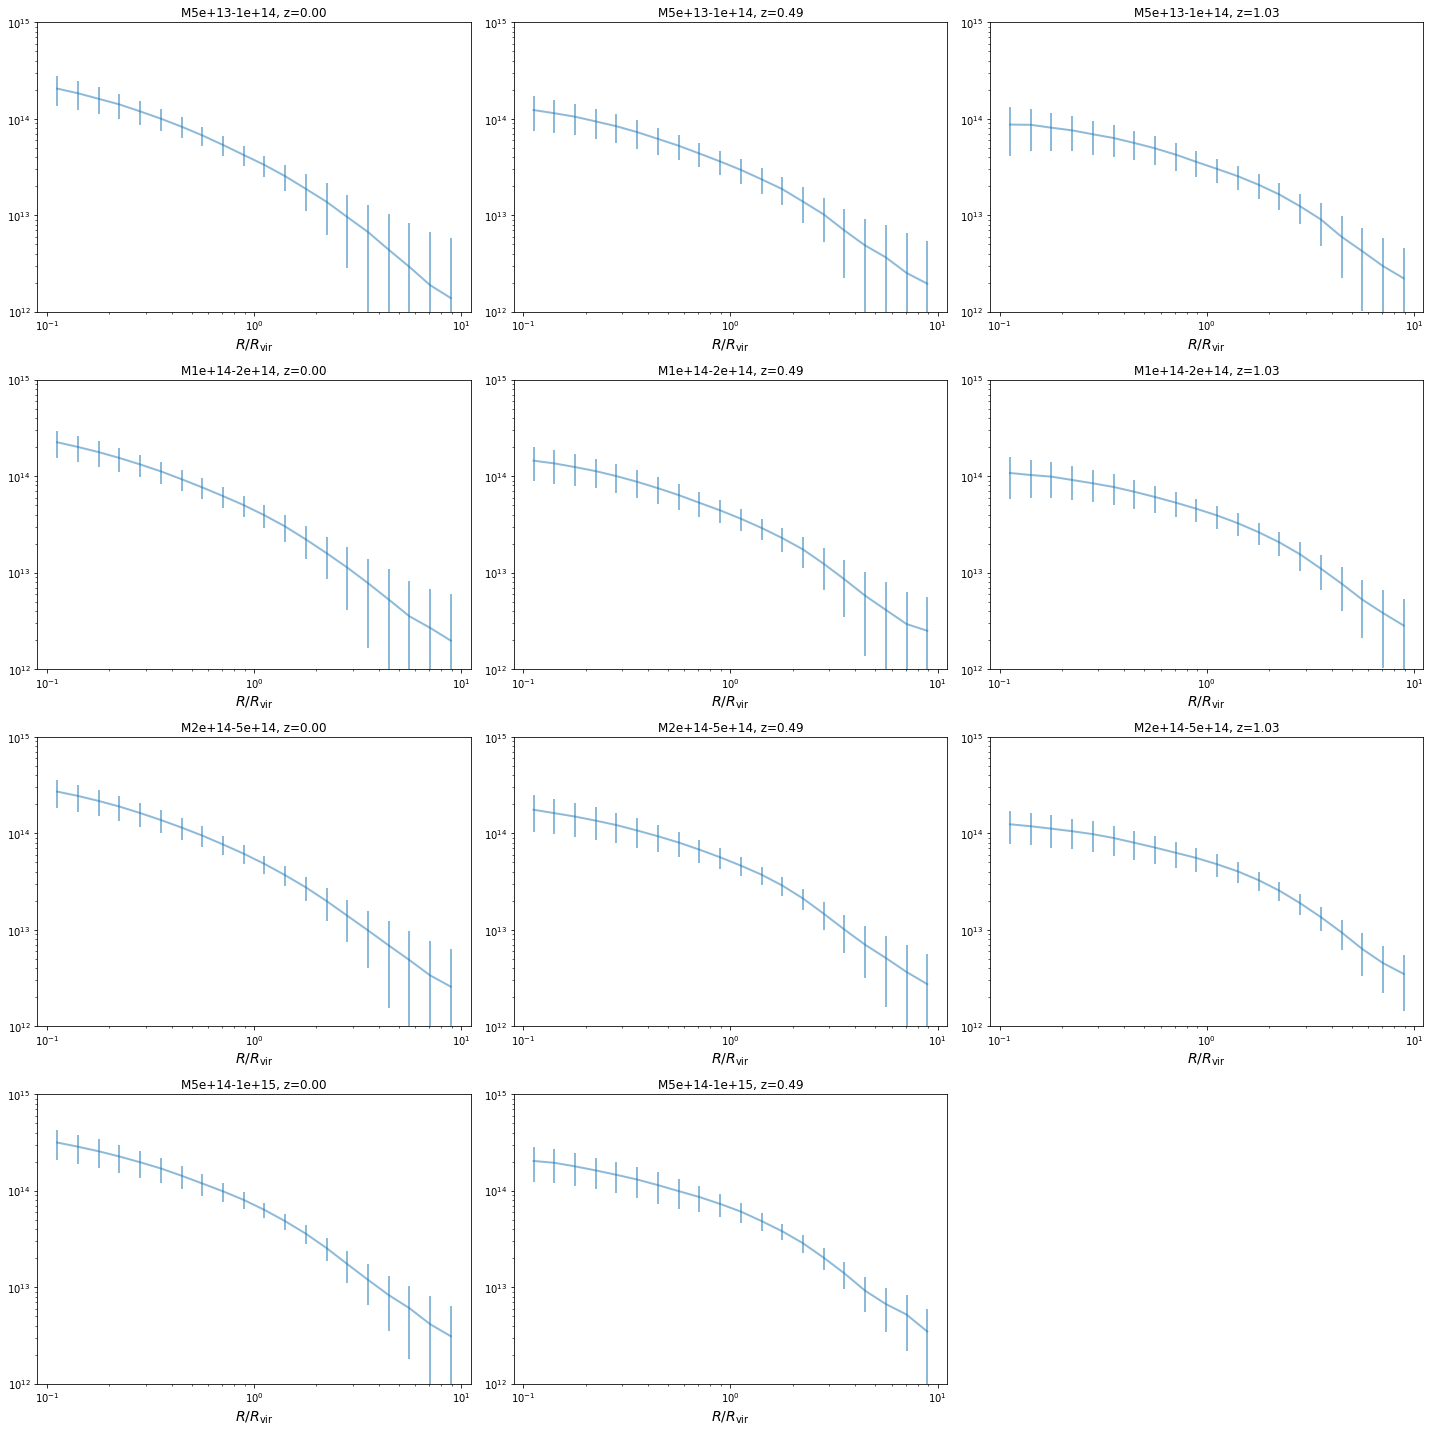

In [16]:
from scipy import stats
nBootstrap = 5
X_params = ['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn']
#X_params = ['c_vir', 'Acc_Rate_2*Tdyn']

fig, axs = plt.subplots(4,3,figsize=(20,20), tight_layout=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        mask = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
        print('M{:.2g}-{:.2g}, z={:.2f}, N={}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))
        
        if len(cur_df) < 100: 
            axs[i,j].set_visible(False)
            continue
        
        DS_cur = np.vstack(cur_df['delta_sigma'])
        DS_all = np.vstack(matched_halo_df['delta_sigma'])
        #axs[i,j].errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr = np.std(DS_all,axis=0), label='All', linewidth=2, alpha=1)
        axs[i,j].errorbar(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), yerr = np.std(DS_cur,axis=0), linewidth=2, alpha=0.5)
        
        
        ##Plotting configu
        axs[i,j].axhline(0,linestyle='dashed', color='black')
        axs[i,j].set_xscale('log'); axs[i,j].set_yscale('log')
        axs[i,j].set_xlabel(r'$R/R_{\rm vir}$', fontsize=14)
        axs[i,j].set_title('M{:.2g}-{:.2g}, z={:.2f}'.format(mass_min, mass_max, 1/cur_a_bin-1))
        axs[i,j].set_ylim([1e12,1e15])
        
#axs[0,0].legend(loc='lower left')

#plt.savefig('cov_time_formation.png')
plt.show()

## Saving the files

In [17]:
pickle.dump(merged_df, open( clusters_dir+ "MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p", "wb" ) )

## Matching the galaxies onto clusters

Do this iteratively for all clusters. 

In [47]:
files = ['sigma_mvir_5e13_1e14_z0p49.pkl', 'sigma_mvir_1e14_2e14_z0p49.pkl', 'sigma_mvir_2e14_5e14_z0p49.pkl'] #, 'sigma_mvir_5e14_1e15_z0p49.pkl']

In [48]:
matched_halos_df = pd.DataFrame(columns=cur_df.columns)

#Need to change the dtype of the new merged dataframe object
matched_halos_df.dtype = cur_df.dtypes
matched_halos_df.dtypes

/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


scale                 object
id                    object
pid                   object
mvir                  object
rvir                  object
rs                    object
Mmvir_all             object
M200b                 object
M200c                 object
M500c                 object
T/|U|                 object
Halfmass_Scale        object
Acc_Rate_Inst         object
Acc_Rate_100Myr       object
Acc_Rate_1*Tdyn       object
Acc_Rate_2*Tdyn       object
Acc_Rate_Mpeak        object
Type                  object
GalaxyIndex           object
CentralGalaxyIndex    object
CtreesHaloID          object
CtreesCentralID       object
CentralMvir           object
StellarMass           object
x                     object
y                     object
z                     object
Ngal                  object
cluster_id            object
sigma                 object
r_range               object
delta_sigma           object
c_vir                 object
dtype: object

In [49]:
first_file_bool = True
for file in iter(files):
    delta_sigma_file = deltasigma_dir + file

    with open(delta_sigma_file, 'rb') as handle:
        deltasigma = pickle.load(handle)
        
    deltasigma_df = pd.DataFrame.from_dict(deltasigma, orient="index").transpose()
        
    cur_df = pd.merge(matched_gal, deltasigma_df, how="inner", left_on='id', right_on='cluster_id')
    cur_df['c_vir'] = cur_df.rvir/cur_df.rs
    
    if first_file_bool:
        matched_halos_df =  cur_df.copy()
    else:
        matched_halos_df = matched_halos_df.append(cur_df, ignore_index=True)
    
    first_file_bool = False
    

In [50]:
matched_halos_df

,scale,id,pid,mvir,rvir,rs,Mmvir_all,M200b,M200c,M500c,...,StellarMass,x,y,z,Ngal,cluster_id,sigma,r_range,delta_sigma,c_vir
0,0.6712,9796437476,-1,5.024900e+13,846.406006,255.557999,5.088600e+13,5.357900e+13,4.246800e+13,2.654200e+13,...,1.033845e+11,179.01086,460.98523,973.94995,43,9796437476,"[-1.1259972595732267e+17, -1.1262208671464421e...","[0.0846406006, 0.10655620296486065, 0.13414631...","[76011039050688.53, 62068407410776.555, 478529...",3.311992
1,0.6712,9796436049,-1,6.149400e+13,905.346008,210.074997,6.164800e+13,6.562400e+13,5.283800e+13,3.620500e+13,...,7.579319e+10,171.86781,458.44656,983.64350,57,9796436049,"[-1.1254668008513418e+17, -1.125829018959067e+...","[0.0905346008, 0.11397630959376054, 0.14348767...","[123987363916505.6, 101085155423152.16, 937104...",4.309632
2,0.6712,9796399651,-1,6.309200e+13,913.117981,123.994003,6.310800e+13,6.452300e+13,5.880700e+13,4.455700e+13,...,1.219390e+11,152.65776,476.10420,927.36240,31,9796399651,"[-1.1250940277181824e+17, -1.125515591817125e+...","[0.09131179810000001, 0.11495474302470836, 0.1...","[95128794535250.94, 86621108023290.12, 8105527...",7.364211
3,0.6712,9787002408,-1,8.178700e+13,995.630005,187.621994,8.180100e+13,8.519000e+13,7.296000e+13,5.289300e+13,...,7.880763e+10,105.85828,480.64713,959.61650,67,9787002408,"[-1.1252454216027234e+17, -1.1257610279183882e...","[0.0995630005, 0.1253423914039254, 0.157796721...","[104978700559505.1, 98769641304917.17, 8856317...",5.306574
4,0.6712,9787002732,-1,9.270900e+13,1038.109985,207.746002,9.283900e+13,9.849700e+13,8.279800e+13,5.770700e+13,...,1.296282e+11,116.91640,459.57288,956.15950,58,9787002732,"[-1.1252234166226166e+17, -1.1260647598016797e...","[0.1038109985, 0.13069030403537618, 0.16452934...","[107139378920712.47, 120685543818893.0, 850219...",4.997015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.6712,9808833636,-1,3.149600e+14,1560.578979,280.393005,3.158900e+14,3.224300e+14,2.897600e+14,2.173700e+14,...,1.034362e+11,260.96295,855.23420,28.24556,168,9808833636,"[-2.632568955787821e+18, -1.7025945479419092e+...","[0.15605789790000002, 0.1964652533774896, 0.24...","[2.520469445874786e+18, 1.59037021342556e+18, ...",5.565684
1496,0.6712,9808870314,-1,2.360100e+14,1417.461060,285.321014,2.360900e+14,2.391400e+14,2.227800e+14,1.536700e+14,...,1.177701e+11,248.26215,868.37850,64.79633,172,9808870314,"[-3.1673260868799846e+18, -2.0400011976705262e...","[0.141746106, 0.1784477748662697, 0.2246524384...","[3.054940688868479e+18, 1.9275645398204099e+18...",4.967952
1497,0.6712,9818904277,-1,2.798400e+14,1500.274048,628.491028,2.798400e+14,2.915900e+14,2.363500e+14,1.313300e+14,...,5.977757e+10,279.51462,892.67170,136.80770,232,9818904277,"[-2.839457396305407e+18, -1.833148551488951e+1...","[0.1500274048, 0.18887331236825025, 0.23777741...","[2.726999260466277e+18, 1.7206429301255726e+18...",2.387105
1498,0.6712,9809524085,-1,2.908600e+14,1519.713989,387.018005,2.911000e+14,3.065800e+14,2.367600e+14,1.574800e+14,...,9.136387e+10,243.99791,897.82680,180.22655,144,9809524085,"[-2.770074933628834e+18, -1.7893701884553106e+...","[0.1519713989, 0.19132065594111816, 0.24085843...","[2.6576850097586627e+18, 1.6769229556094676e+1...",3.926727


In [51]:
##Goal is to change the datatypes of the dataframe. 

matched_halos_df.dtypes

scale                 float64
id                     object
pid                     int64
mvir                  float64
rvir                  float64
rs                    float64
Mmvir_all             float64
M200b                 float64
M200c                 float64
M500c                 float64
T/|U|                 float64
Halfmass_Scale        float64
Acc_Rate_Inst         float64
Acc_Rate_100Myr       float64
Acc_Rate_1*Tdyn       float64
Acc_Rate_2*Tdyn       float64
Acc_Rate_Mpeak        float64
Type                    int64
GalaxyIndex             int64
CentralGalaxyIndex      int64
CtreesHaloID            int64
CtreesCentralID         int64
CentralMvir           float64
StellarMass           float64
x                     float64
y                     float64
z                     float64
Ngal                    int64
cluster_id             object
sigma                  object
r_range                object
delta_sigma            object
c_vir                 float64
dtype: obj

In [52]:
matched_halos_df['c_vir']

0       3.311992
1       4.309632
2       7.364211
3       5.306574
4       4.997015
          ...   
1495    5.565684
1496    4.967952
1497    2.387105
1498    3.926727
1499    4.630034
Name: c_vir, Length: 1500, dtype: float64